# Sentiment Analysis on TripAdvisor  Data

Load the Libraries

In [1]:
!pip install spaCy

In [3]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=187ae4d476aff04cb00345ef9324695a55aee35a11ace339d171e82039b14ce6
  Stored in directory: /tmp/pip-ephem-wheel-cache-m_sasve0/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [1]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [2]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
!pip install beautifulsoup4

In [4]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [5]:
nltk.download('conll2000')

[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.


True

In [7]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

Upload Data

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
import os
PATH = os.getcwd()
DATADIR = PATH + '/drive/My Drive/Long.csv'

In [10]:
#Read data
df = pd.read_csv(DATADIR)
df.shape

(4518, 4)

In [11]:
df.head()

,Index,Source,Text,Length
0,1,Susanli,An unfounded conspiracy theory and pro-Kremlin...,1001
1,2,Susanli,To all my wonderful people in Liberia: While y...,1002
2,3,Susanli,Microsoft has recently patented an invention t...,1003
3,4,Susanli,We are moving towards a totalitarian state of ...,1009
4,5,Susanli,A top U.S. scientist and research pioneer Dr. ...,1018


In [12]:
import spacy
import en_core_web_lg
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
import unicodedata

nlp = en_core_web_lg.load()
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')

# Want to keep negative stop words for sentiment analysis
stopword_list.remove('no')
stopword_list.remove('not')

In [13]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>text text text</h2></html>')

'text text text'

In [14]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('some accented letters â î or ô')

'some accented letters a i or o'

In [15]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [16]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
            if contraction_mapping.get(match) \
            else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
    
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("y'all I've don't I'd we're")

'you all I have do not I would we are'

In [17]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("S0me sp3ci@l c#@4@c|3rs *&)@&)@#&", remove_digits=True)

'Sme spcil ccrs '

In [18]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text(str(df.Text[0]))

"an unfounded conspiracy theory and pro - kremlin disinformation narrative about the ongoing coronavirus pandemic . the first case of COVID-19 be report in China , in the city of Wuhan on December 31 . on that day , China alert the who about several case of pneumonia from an unknown cause . some of those infect work at the city 's Huanan Seafood Wholesale Market , which be believe to be the place where the new disease originate . very quickly , the number of those infect rise to over 40.On January 13 , the coronavirus be confirm in Thailand , in Japan on January 16 and in North Korea and the United States on January 20 . in Japan , the first case of coronavirus be confirm in a resident of Kanagawa Prefecture who have travel to Wuhan at the beginning of January . the first case in Italy be confirm on January 30 , when two chinese tourist in Rome test positive for the virus . a week later the third case be confirm in an italian man who be repatriate back to Italy from Wuhan ."

In [19]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

remove_stopwords(str(df.Text[0]))

"unfounded conspiracy theory pro-Kremlin disinformation narrative ongoing coronavirus pandemic.The first cases COVID-19 reported China , city Wuhan December 31. day , China alerted several cases pneumonia unknown cause. infected worked city ' Huanan Seafood Wholesale Market , believed place new disease originated. quickly , number infected rose 40.On January 13 , coronavirus confirmed Thailand , Japan January 16 North Korea United States January 20. Japan , first case coronavirus confirmed resident Kanagawa Prefecture travelled Wuhan beginning January.The first case Italy confirmed January 30 , two Chinese tourists Rome tested positive virus. week later third case confirmed Italian man repatriated back Italy Wuhan ."

In [20]:
def normalize_corpus(corpus, html_stripping=True, accented_char_removal=True, contraction_expansion=True, 
                    text_lower_case=True, text_lemmatization=True, special_char_removal=True, stopword_removal=True,
                    remove_digits=True):
    normalized_corpus = []
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions
        if contraction_expansion:
            doc = expand_contractions(doc)
        # turn into lowercase
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ', doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and/or digits
        if special_char_removal:
            # insert spaces between special characters to isolate them
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)
        # remove extra whitespaces
        doc = re.sub(' _', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
    
    return normalized_corpus

In [21]:
# combine news headline and article text into one doc
df['full_text'] = df["Text"]

# pre-process text
df['clean_text'] = normalize_corpus(df['full_text'])
norm_corpus = list(df['clean_text'])
df.iloc[1][['full_text', 'clean_text']].to_dict()

{'clean_text': 'wonderful people liberia lockdown open eye please see anything like instal community take picture post online engage government g mast pole atenae look thing beam radiation make sick kill month symptom like novel coronavirus even damage human body like respitory fatality heart deform babe destruction sperm tooth much mainline medium heavily pay disassociate g coronavirus many time shame anybody evil government put indoors letor telecom company thing bring harm religious leader good politician business people general public see g mast better get house talk stop priority need attention not high technology destroy',
 'full_text': 'To all my wonderful people in Liberia: While you are under lockdown, open your eyes please. If you see anything like this being installed in your communities, take a picture and post it online, and engage the government. This is how some of the 5G masts/poles/atenaes look. These things beam radiation that will make you sick and kill you in 3 to 6

# Text Parsing

POS Tagging


In [22]:
# pre-process, but don't lowercase or lemmatize to get POS context
corpus = normalize_corpus(df['full_text'], text_lower_case=False, text_lemmatization=False, special_char_removal=False)

# demo for POS tagging
sentence = str(df.iloc[0].Text)
sentence_nlp = nlp(sentence)

# POS tagging with spacy
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
df_spacy_pos_tagged = pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])

# POS tagging with nltk
nltk_pos_tagged = nltk.pos_tag(sentence.split())
df_nltk_pos_tagged = pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])


In [23]:
sentence

"An unfounded conspiracy theory and pro-Kremlin disinformation narrative about the ongoing coronavirus pandemic.The first cases of COVID-19 were reported in China, in the city of Wuhan on December 31. On that day, China alerted the WHO about several cases of pneumonia from an unknown cause. Some of those infected worked at the city's Huanan Seafood Wholesale Market, which is believed to be the place where the new disease originated. Very quickly, the number of those infected rose to over 40.On January 13, the coronavirus was confirmed in Thailand, in Japan on January 16 and in North Korea and the United States on January 20. In Japan, the first case of coronavirus was confirmed in a resident of Kanagawa Prefecture who had travelled to Wuhan at the beginning of January.The first case in Italy was confirmed on January 30, when two Chinese tourists in Rome tested positive for the virus. A week later the third case was confirmed in an Italian man who was repatriated back to Italy from Wuha

In [24]:
df_spacy_pos_tagged

,Word,POS tag,Tag type
0,An,DT,DET
1,unfounded,JJ,ADJ
2,conspiracy,NN,NOUN
3,theory,NN,NOUN
4,and,CC,CCONJ
...,...,...,...
185,to,IN,ADP
186,Italy,NNP,PROPN
187,from,IN,ADP
188,Wuhan,NNP,PROPN


In [25]:
df_nltk_pos_tagged

,Word,POS tag
0,An,DT
1,unfounded,JJ
2,conspiracy,NN
3,theory,NN
4,and,CC
...,...,...
164,back,RB
165,to,TO
166,Italy,NNP
167,from,IN


Shallow Parsing (Chunking)

In [26]:
# using nltk conll2000 corpus to train the shallow parser model
from nltk.corpus import conll2000

data = conll2000.chunked_sents()
train_data = data[:10900]
test_data = data[10900:]

print(len(train_data), len(test_data))
print(train_data[0])

10900 48
(S
  (NP Confidence/NN)
  (PP in/IN)
  (NP the/DT pound/NN)
  (VP is/VBZ widely/RB expected/VBN to/TO take/VB)
  (NP another/DT sharp/JJ dive/NN)
  if/IN
  (NP trade/NN figures/NNS)
  (PP for/IN)
  (NP September/NNP)
  ,/,
  due/JJ
  (PP for/IN)
  (NP release/NN)
  (NP tomorrow/NN)
  ,/,
  (VP fail/VB to/TO show/VB)
  (NP a/DT substantial/JJ improvement/NN)
  (PP from/IN)
  (NP July/NNP and/CC August/NNP)
  (NP 's/POS near-record/JJ deficits/NNS)
  ./.)


In [27]:
from nltk.chunk.util import tree2conlltags, conlltags2tree

wtc = tree2conlltags(train_data[0])
wtc

[('Confidence', 'NN', 'B-NP'),
 ('in', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('pound', 'NN', 'I-NP'),
 ('is', 'VBZ', 'B-VP'),
 ('widely', 'RB', 'I-VP'),
 ('expected', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('take', 'VB', 'I-VP'),
 ('another', 'DT', 'B-NP'),
 ('sharp', 'JJ', 'I-NP'),
 ('dive', 'NN', 'I-NP'),
 ('if', 'IN', 'O'),
 ('trade', 'NN', 'B-NP'),
 ('figures', 'NNS', 'I-NP'),
 ('for', 'IN', 'B-PP'),
 ('September', 'NNP', 'B-NP'),
 (',', ',', 'O'),
 ('due', 'JJ', 'O'),
 ('for', 'IN', 'B-PP'),
 ('release', 'NN', 'B-NP'),
 ('tomorrow', 'NN', 'B-NP'),
 (',', ',', 'O'),
 ('fail', 'VB', 'B-VP'),
 ('to', 'TO', 'I-VP'),
 ('show', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('substantial', 'JJ', 'I-NP'),
 ('improvement', 'NN', 'I-NP'),
 ('from', 'IN', 'B-PP'),
 ('July', 'NNP', 'B-NP'),
 ('and', 'CC', 'I-NP'),
 ('August', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('near-record', 'JJ', 'I-NP'),
 ('deficits', 'NNS', 'I-NP'),
 ('.', '.', 'O')]

In [28]:
# extract POS and chunk tags from sentences with chunked annotations
def conll_tags_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]

# function to train multiple taggers
def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff

In [29]:
%%time

from nltk.tag import UnigramTagger, BigramTagger, TrigramTagger
from nltk.chunk import ChunkParserI

# chunker class
class NGramTagChunker(ChunkParserI):
    def __init__(self, train_sentences, tagger_classes=[UnigramTagger, BigramTagger]):
        # get the POS and chunk tags using our function above
        train_sent_tags = conll_tags_chunks(train_sentences)
        # train chunk tagger from POS tags
        self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)
    
    def parse(self, tagged_sentence):
        if not tagged_sentence:
            return None
        # get POS tags from our tagged sentence
        pos_tags = [tag for word, tag in tagged_sentence]
        # Get chunk tags from the trained taggers
        chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
        chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
        # Combine token, pos tag and chunk tags
        wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                       in zip(tagged_sentence, chunk_tags)]
        return conlltags2tree(wpc_tags)
    
# train chunker model
ntc = NGramTagChunker(train_data)

# evaluate chunker model performance
print('Performance on training data:\n', ntc.evaluate(train_data))
print()
print('Performance on test data:\n', ntc.evaluate(test_data))
        

Performance on training data:
 ChunkParse score:
    IOB Accuracy:  89.4%%
    Precision:     80.9%%
    Recall:        86.2%%
    F-Measure:     83.5%%

Performance on test data:
 ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%
CPU times: user 8.82 s, sys: 207 ms, total: 9.03 s
Wall time: 9.05 s


In [30]:
chunk_tree = ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  (NP An/DT unfounded/JJ conspiracy/NN theory/NN)
  and/CC
  (NP pro-Kremlin/JJ disinformation/NN narrative/JJ)
  (PP about/IN)
  (NP
    the/DT
    ongoing/JJ
    coronavirus/NN
    pandemic.The/NN
    first/JJ
    cases/NNS)
  (PP of/IN)
  (NP COVID-19/NNP)
  (VP were/VBD reported/VBN)
  (PP in/IN)
  (NP China,/NNP)
  (PP in/IN)
  (NP the/DT city/NN)
  (PP of/IN)
  (NP Wuhan/NNP)
  (PP on/IN)
  (NP December/NNP 31./CD)
  (PP On/IN)
  (NP that/DT day,/JJ China/NNP)
  (VP alerted/VBD)
  (NP the/DT WHO/NNP)
  (PP about/IN)
  (NP several/JJ cases/NNS)
  (PP of/IN)
  (NP pneumonia/NN)
  (PP from/IN)
  (NP an/DT unknown/JJ cause./NN)
  (NP Some/DT)
  (PP of/IN)
  (NP those/DT infected/VBN)
  (VP worked/VBD)
  (PP at/IN)
  (NP
    the/DT
    city's/NN
    Huanan/NNP
    Seafood/NNP
    Wholesale/NNP
    Market,/NNP)
  (NP which/WDT)
  (VP is/VBZ believed/VBN to/TO be/VB)
  (NP the/DT place/NN)
  where/WRB
  (NP the/DT new/JJ disease/NN originated./JJ Very/NNP)
  (VP quickly,/VBZ)
  (NP t

# Sentiment Analysis

In [31]:
!pip install afinn

     |████████████████████████████████| 61kB 3.1MB/s 
  Created wheel for afinn: filename=afinn-0.1-cp36-none-any.whl size=53453 sha256=88aeb71cf57ce9c4a3422f87641882b9670ed3c99f51040dff169b2517f43bbe
  Stored in directory: /root/.cache/pip/wheels/b5/1c/de/428301f3333ca509dcf20ff358690eb23a1388fbcbbde008b2
Successfully built afinn


In [32]:
from afinn import Afinn
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                          else 'neutral' 
                          for score in sentiment_scores]

# sentiment statistics per news category
dfA = pd.DataFrame([list(df['Text']), sentiment_scores, sentiment_category]).T
dfA.columns = ['Text', 'sentiment_score', 'sentiment_category']
dfA['sentiment_score'] = dfA.sentiment_score.astype('float')
dfA.head()

,Text,sentiment_score,sentiment_category
0,An unfounded conspiracy theory and pro-Kremlin...,-4.0,negative
1,To all my wonderful people in Liberia: While y...,-8.0,negative
2,Microsoft has recently patented an invention t...,-1.0,negative
3,We are moving towards a totalitarian state of ...,3.0,positive
4,A top U.S. scientist and research pioneer Dr. ...,-25.0,negative


In [33]:
dfA.groupby(by=['sentiment_category']).describe()

sentiment_score                        ...                   
                             count       mean        std  ...   50%   75%    max
sentiment_category                                        ...                   
negative                    3437.0 -27.713995  28.880277  ... -19.0 -10.0   -1.0
neutral                       80.0   0.000000   0.000000  ...   0.0   0.0    0.0
positive                    1001.0  12.215784  12.956982  ...   8.0  16.0  125.0

[3 rows x 8 columns]

In [ ]:
dfA.groupby(by=['CONTINENT']).describe().to_csv("affin continentwise description.csv")

In [34]:
import seaborn as sns

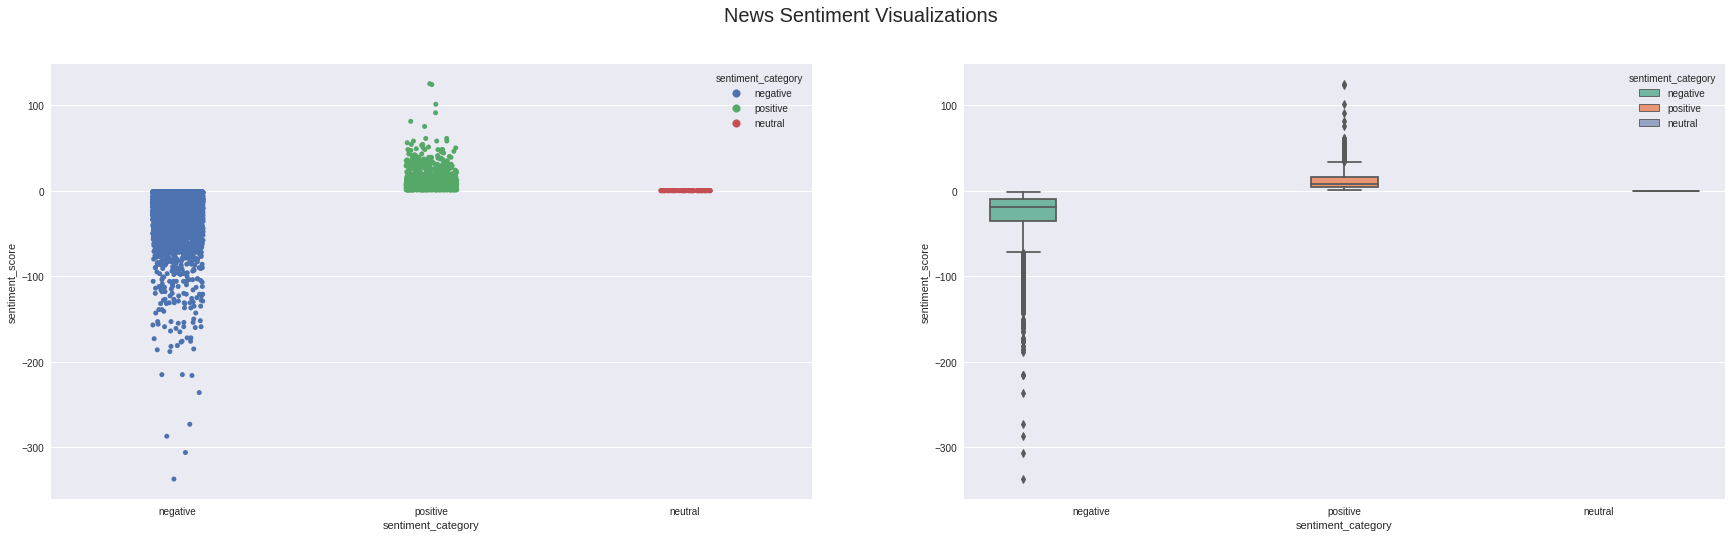

In [35]:
plt.style.use("seaborn")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 8))
sp = sns.stripplot(x='sentiment_category', y='sentiment_score', 
                   hue='sentiment_category', data=dfA, ax=ax1)
bp = sns.boxplot(x='sentiment_category', y='sentiment_score', 
                 hue='sentiment_category', data=dfA, palette='Set2', ax=ax2)
t = f.suptitle('News Sentiment Visualizations', fontsize=20)

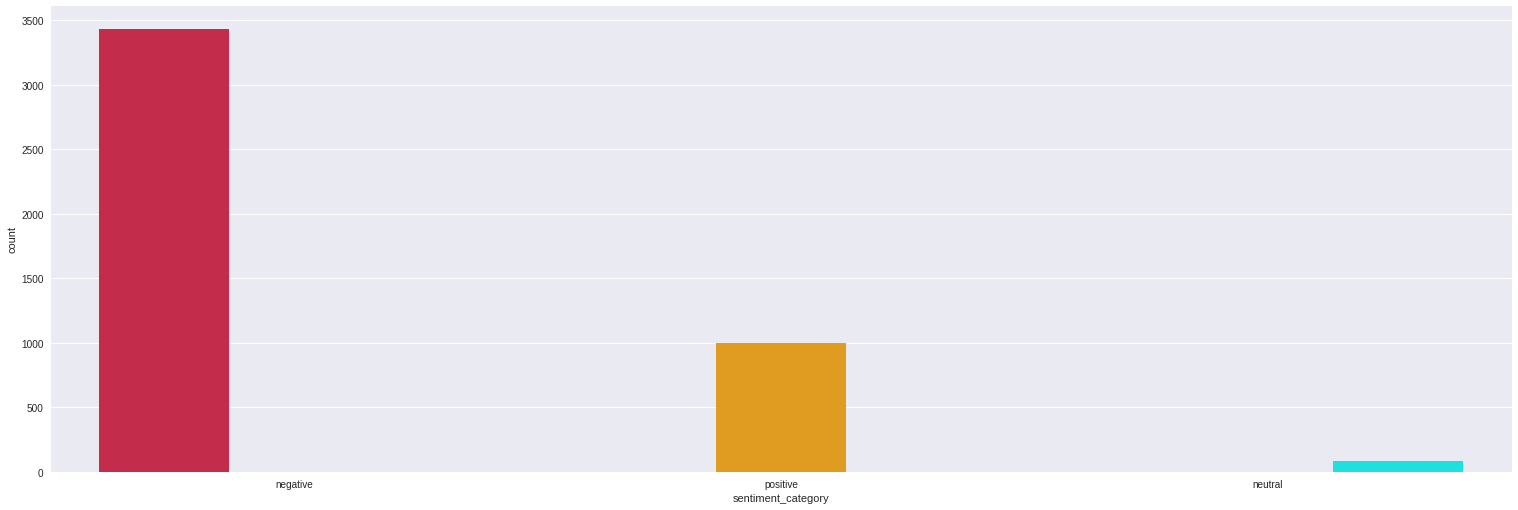

In [37]:
# frequency of sentiment labels
#plt.figure(figsize=(200,20))
fc = sns.catplot(x="sentiment_category", hue="sentiment_category", 
                 data=dfA, kind="count",
                 palette={'negative': 'crimson',
                          'positive': 'orange',
                          'neutral': 'aqua'}, height=7, aspect=3)

Text Blob

In [38]:
from textblob import TextBlob

# computer sentiment scores (polarty) and labels
sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in df['clean_text']]
sentiment_category_tb = ['positive' if score > 0 
                          else 'negative' if score < 0 
                          else 'neutral' 
                          for score in sentiment_scores_tb]

# sentiment statistics per news category
dfT = pd.DataFrame([list(df['Text']), sentiment_scores_tb, sentiment_category_tb]).T
dfT.columns = ['Text', 'sentiment_score', 'sentiment_category']
dfT['sentiment_score'] = dfT.sentiment_score.astype('float')
dfT.head()
#df.groupby(by=['COUNTRY']).describe()

,Text,sentiment_score,sentiment_category
0,An unfounded conspiracy theory and pro-Kremlin...,0.104,positive
1,To all my wonderful people in Liberia: While y...,0.050,positive
2,Microsoft has recently patented an invention t...,0.123,positive
3,We are moving towards a totalitarian state of ...,-0.074,negative
4,A top U.S. scientist and research pioneer Dr. ...,0.045,positive


In [ ]:
dfT.to_csv('textblobresults.csv')

In [39]:
dfT.groupby(by=['sentiment_category']).describe()

sentiment_score                      ...                     
                             count      mean       std  ...    50%    75%    max
sentiment_category                                      ...                     
negative                    1619.0 -0.043172  0.038245  ... -0.033 -0.015 -0.001
neutral                       31.0  0.000000  0.000000  ...  0.000 -0.000 -0.000
positive                    2868.0  0.056508  0.042395  ...  0.048  0.079  0.312

[3 rows x 8 columns]

In [ ]:
dfA.groupby(by=['CONTINENT']).describe().to_csv("textblob continentwise description.csv")

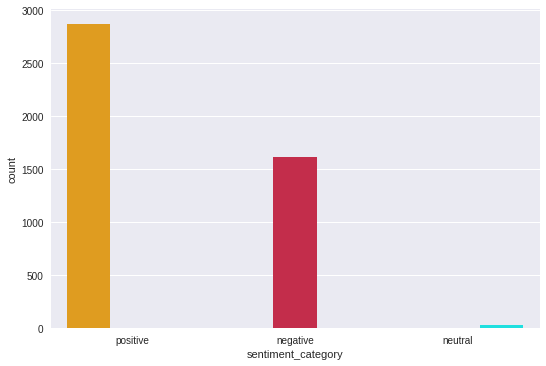

In [40]:
fc = sns.catplot(x="sentiment_category", hue="sentiment_category", 
                    data=dfT, kind="count", 
                    palette={'negative': 'crimson',
                             'positive': 'orange',
                             'neutral': 'aqua'}, height=5, aspect=1.5)

Comparison

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, ax, vmax=None,
                          normed=True, title='Confusion matrix',
                          class_names=None, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if normed:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, vmax=vmax, annot=True, square=True, ax=ax, 
                cmap='Blues', cbar=False, linecolor='k',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, fontsize=16)
    if not labels:
        labels=['True Labels', 'Predicted Labels']

    ax.set_ylabel(labels[0], fontsize=12)
    ax.set_xlabel(labels[1], y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

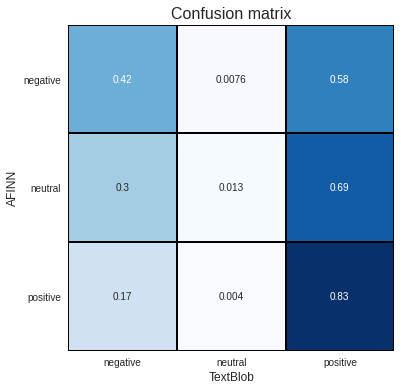

In [42]:
fig, (axis1) = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
plot_confusion_matrix(sentiment_category, sentiment_category_tb, ax=axis1,
                      class_names=['negative', 'neutral', 'positive'],
                      labels=['AFINN', 'TextBlob'])